# Localized Translations A/B Testing Case Study
Brian Amadio

# 1. Investigate if the test is actually negative

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
test_df = pd.read_csv('Translation_Test__281_29/test_table.csv')
user_df = pd.read_csv('Translation_Test__281_29/user_table.csv')
df = pd.merge(test_df,user_df,on='user_id')

In [2]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [3]:
print(len(df),len(df.country.unique()))

452867 17


## Only include users whose browser language is set to English

In [14]:
df=df[df['browser_language']=='ES']

### Basic cleaning
Check for null values

In [16]:
df.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         225874
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

## t-test
Test the null hypothesis that the means of the two samples are equal

In [17]:
from scipy.stats import ttest_ind
print(df.groupby('test')['conversion'].mean())

test
0    0.055431
1    0.043519
Name: conversion, dtype: float64


In [18]:
np.std(df[df['test']==0].conversion),np.std(df[df['test']==1].conversion)

(0.2288190064380263, 0.20402322429345532)

In [19]:
ttest_ind(df[df['test']==1].conversion,df[df['test']==0].conversion,equal_var=False)

Ttest_indResult(statistic=-16.89936348086805, pvalue=4.8023135805267886e-64)

The t-test suggests a highly significant result, but let's dig a little deeper

## Checking sample randomization with chi-square test
The simplest thing we could do is check if the two group sizes are compatible with users being randomly assigned with probability 50%. If this is the case, we expect the group sizes to be distributed according to the binomial distribution with p = .5

For large N, we can approximate the binomial distribution as normal, and use a simple chi-square test

In [20]:
df['conversion'].count()/2

188580.0

In [21]:
df.groupby('test')['conversion'].count()

test
0    197562
1    179598
Name: conversion, dtype: int64

In [22]:
from scipy.stats import chisquare
chisquare(f_obs=df.groupby('test')['conversion'].count())

Power_divergenceResult(statistic=855.6190900413618, pvalue=4.3648469083880244e-188)

Conclusion: too many users are being assigned to the control group

## Exploring the distributions
Before doing any more statistical tests, it's worthwhile to just plot the distributions of various features to see if anything obvious stands out

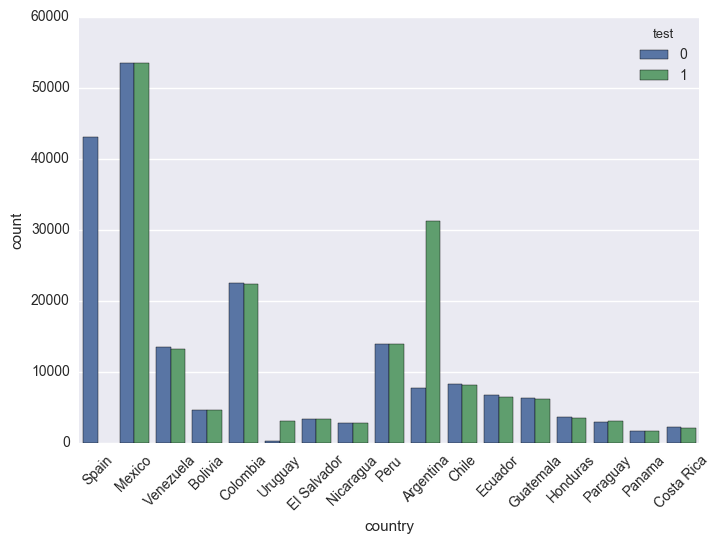

In [23]:
import seaborn as sns
country_plot=sns.countplot(x='country',hue='test',data=df)
for label in country_plot.get_xticklabels():
    label.set_rotation(45)

Obvious mistakes: Including users from Spain the experiment, over-assigning users from Uruguay and Argentina to the test group

## Mean per-country conversion rate

In [24]:
df.groupby('country')['conversion'].mean().mean()

0.04772627038211978

In [25]:
df.groupby('country')['conversion'].mean()

country
Argentina      0.014334
Bolivia        0.049492
Chile          0.048987
Colombia       0.051951
Costa Rica     0.052307
Ecuador        0.049615
El Salvador    0.051808
Guatemala      0.050595
Honduras       0.049812
Mexico         0.050455
Nicaragua      0.054294
Panama         0.049848
Paraguay       0.047134
Peru           0.049929
Spain          0.079799
Uruguay        0.010712
Venezuela      0.050275
Name: conversion, dtype: float64

Argentina and Uruguay stand out as having much lower than average conversion rates, while Spain stands out as having a much higher than average conversion rate

## Chi-squared test for Uruguay and Argentina
Testing the hypothesis that users were assigned to test or control group with probability 50%

In [26]:
df[df['country'].isin(['Uruguay','Argentina'])].groupby(['country','test'])['user_id'].count()

country    test
Argentina  0        7793
           1       31204
Uruguay    0         356
           1        3098
Name: user_id, dtype: int64

In [27]:
x_uru,p_uru = chisquare(df[df['country']=='Uruguay'].groupby('test')['user_id'].count())
x_arg,p_arg = chisquare(df[df['country']=='Argentina'].groupby('test')['user_id'].count())

In [28]:
print('p-value for Uruguay = %f, p-value for Argentina = %f '%(p_uru,p_arg))

p-value for Uruguay = 0.000000, p-value for Argentina = 0.000000 


### Remove Spain from test
Keep the data for Argentina and Uruguay separate for further tests

In [29]:
df=df[df['country']!='Spain']
df_arg = df[df['country']=='Argentina']
df_uru = df[df['country']=='Uruguay']

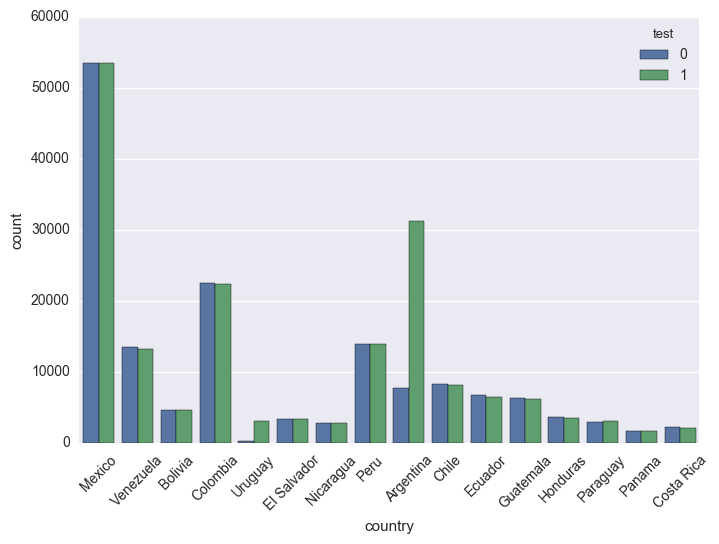

In [30]:
country_plot=sns.countplot(x='country',hue='test',data=df)
for label in country_plot.get_xticklabels():
    label.set_rotation(45)

## t-test with three offending countries removed

In [31]:
df[~df['country'].isin(['Argentina','Uruguay'])].groupby('test')['conversion'].count()

test
0    146267
1    145296
Name: conversion, dtype: int64

In [32]:
chisquare(df[~df['country'].isin(['Argentina','Uruguay'])].groupby('test')['conversion'].count())

Power_divergenceResult(statistic=3.233747080390859, pvalue=0.072135460686012509)

In [33]:
df[~df['country'].isin(['Argentina','Uruguay'])].groupby('test')['conversion'].mean()

test
0    0.050490
1    0.050538
Name: conversion, dtype: float64

In [34]:
samp1 = df[(~df['country'].isin(['Argentina','Uruguay']))&(df['test']==1)].conversion
samp2 = df[(~df['country'].isin(['Argentina','Uruguay']))&(df['test']==0)].conversion

In [35]:
ttest_ind(samp1,samp2)

Ttest_indResult(statistic=0.059609474976514906, pvalue=0.95246671270423033)

## Tracking test and control group sizes over time

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


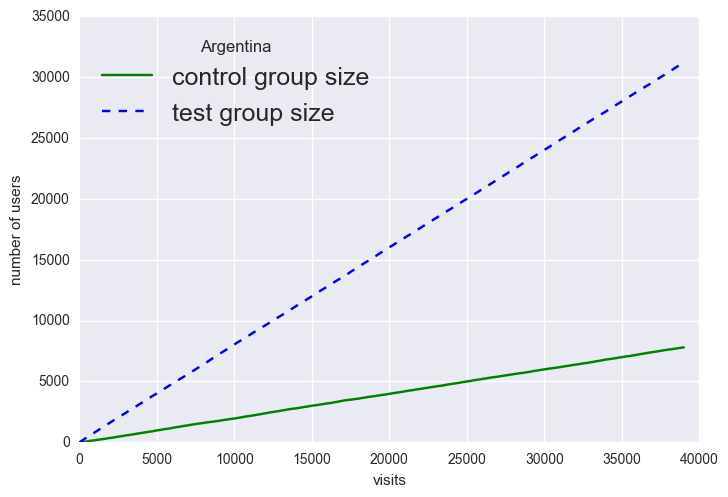

In [36]:
df_arg.loc[:,'date'] = pd.to_datetime(df_arg.loc[:,'date'])
df_arg = df_arg.sort_values('date')
df_arg['test_size']=df_arg['test'].cumsum()
df_arg['dummy']=1
df_arg['control_size'] = df_arg['dummy'].cumsum()-df_arg['test_size']
df_arg=df_arg.drop('dummy',1)
plt.plot(np.arange(len(df_arg)),df_arg['control_size'],'g-',label='control group size')
plt.plot(np.arange(len(df_arg)),df_arg['test_size'],'b-',label='test group size',linestyle='--')
plt.legend(loc=0,title='Argentina',fontsize=18)
plt.xlabel('visits')
plt.ylabel('number of users');

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


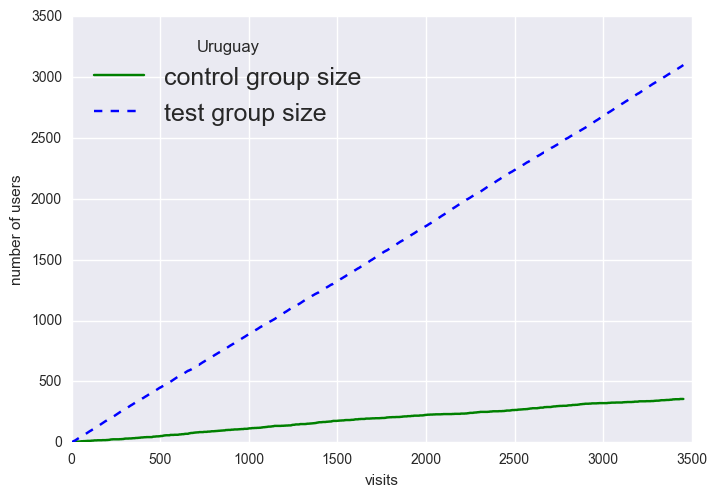

In [37]:
df_uru.loc[:,'date'] = pd.to_datetime(df_uru.loc[:,'date'])
df_uru = df_uru.sort_values('date')
df_uru['test_size']=df_uru['test'].cumsum()
df_uru['dummy']=1
df_uru['control_size'] = df_uru['dummy'].cumsum()-df_uru['test_size']
df_uru=df_uru.drop('dummy',1)

plt.plot(np.arange(len(df_uru)),df_uru['control_size'],'g-',label='control group size')
plt.plot(np.arange(len(df_uru)),df_uru['test_size'],'b-',label='test group size',linestyle='--')
plt.legend(loc=0,title='Uruguay',fontsize=18)
plt.xlabel('visits')
plt.ylabel('number of users');

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


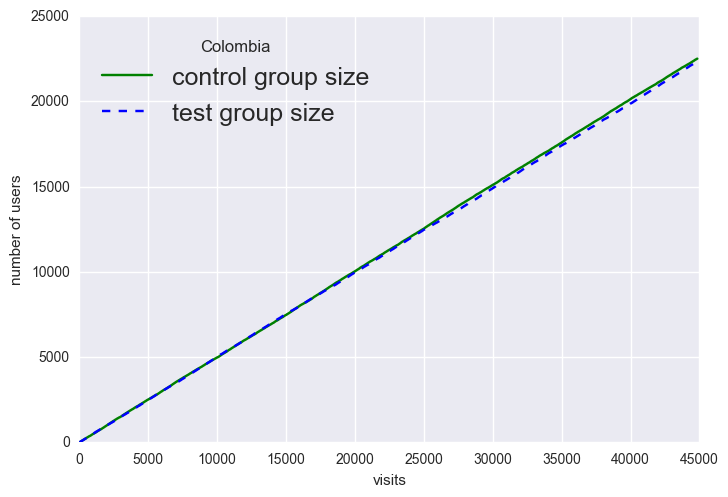

In [38]:
df_col = df[df['country']=='Colombia']
df_col.loc[:,'date'] = pd.to_datetime(df_col.loc[:,'date'])
df_col = df_col.sort_values('date')
df_col['test_size']=df_col['test'].cumsum()
df_col['dummy']=1
df_col['control_size'] = df_col['dummy'].cumsum()-df_col['test_size']
df_col=df_col.drop('dummy',1)

plt.plot(np.arange(len(df_col)),df_col['control_size'],'g-',label='control group size')
plt.plot(np.arange(len(df_col)),df_col['test_size'],'b-',label='test group size',linestyle='--')
plt.legend(loc=0,title='Colombia',fontsize=18)
plt.xlabel('visits')
plt.ylabel('number of users');

# t-tests for individual countries

In [39]:
header=['country','t','p-value']
print("{:>20} {:>20} {:>20}".format(*header))
print('           -------------------------------')
for country in df['country'].unique():
    samp1 = df[(df['country']==country)&(df['test']==1)].conversion
    samp2 = df[(df['country']==country)&(df['test']==0)].conversion
    t,p = ttest_ind(samp1,samp2,equal_var=False)
    row = [country,'{:.2g}'.format(t),'{:.2g}'.format(p)]
    print("{: >20} {: >20} {: >20}".format(*row))

             country                    t              p-value
           -------------------------------
              Mexico                 0.72                 0.47
           Venezuela                -0.33                 0.74
             Bolivia               -0.032                 0.97
            Colombia                -0.89                 0.37
             Uruguay                 0.49                 0.62
         El Salvador                 -1.1                 0.28
           Nicaragua                 0.09                 0.93
                Peru                 0.41                 0.68
           Argentina                -0.86                 0.39
               Chile                 0.41                 0.68
             Ecuador                -0.42                 0.67
           Guatemala                 0.36                 0.72
            Honduras                -0.31                 0.75
            Paraguay               -0.032                 0.97
            

## Check if any other distributions are significantly different between control and test groups

In [40]:
df_2 = df[~df['country'].isin(['Argentina','Uruguay'])]

In [41]:
df_2.groupby('country')['user_id'].count()

country
Bolivia          9254
Chile           16433
Colombia        44850
Costa Rica       4378
Ecuador         13262
El Salvador      6775
Guatemala       12610
Honduras         7167
Mexico         107086
Nicaragua        5636
Panama           3290
Paraguay         6089
Peru            28000
Venezuela       26733
Name: user_id, dtype: int64

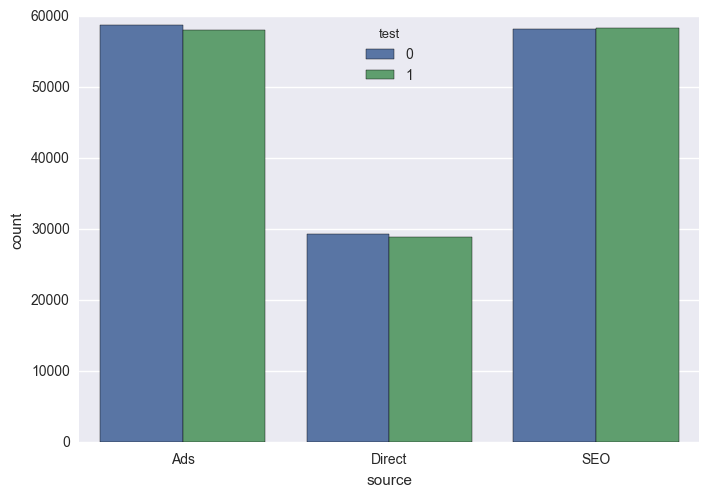

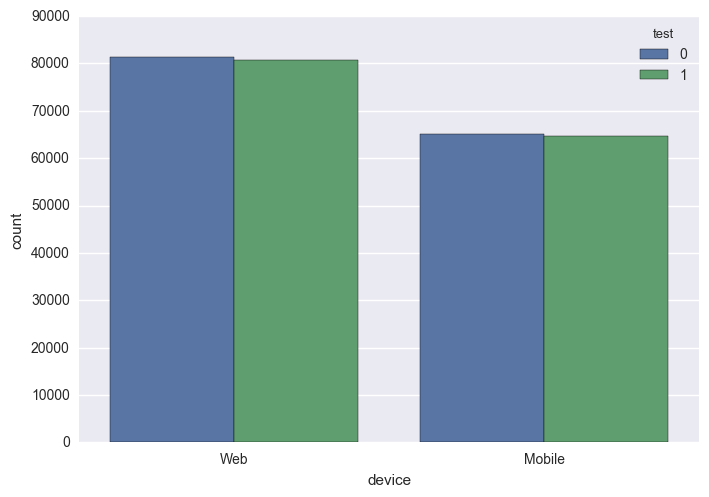

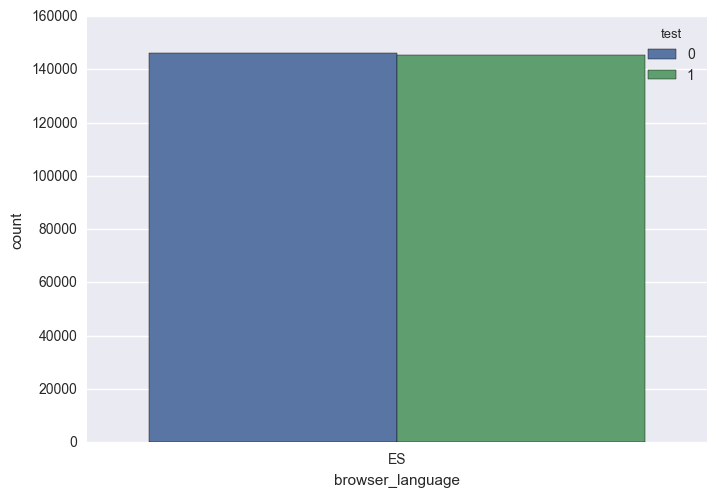

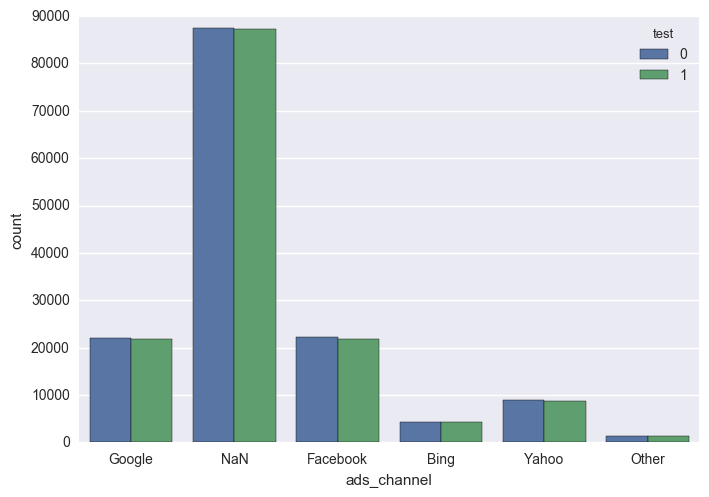

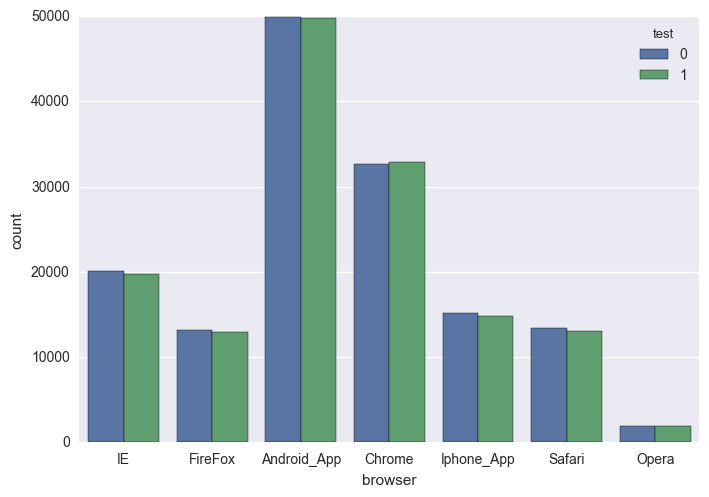

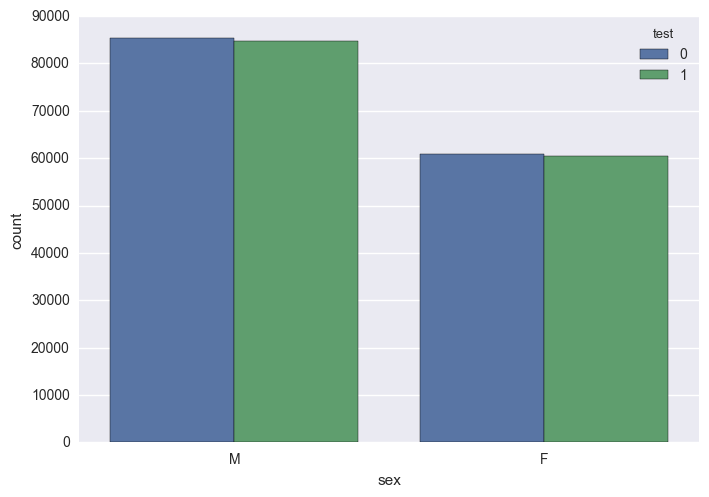

In [42]:
df_2=df_2.fillna('NaN')
cols=['source','device','browser_language','ads_channel','browser','sex']
for col in cols:
    plt.figure()
    plot = sns.countplot(x=col,hue='test',data=df_2)

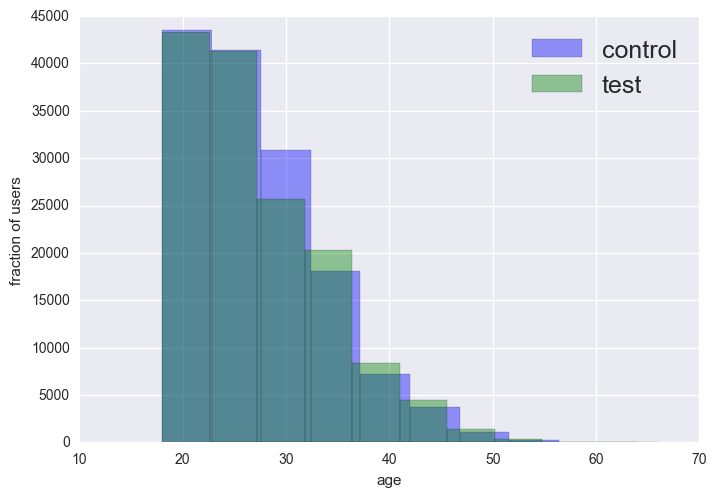

In [44]:
plt.hist(df_2[df_2['test']==0].age,alpha=0.4,label='control',color='b',bins=10)
plt.hist(df_2[df_2['test']==1].age,alpha=0.4,label='test',color='g',bins=10)
plt.legend(fontsize=18)
plt.xlabel('age')
plt.ylabel('fraction of users')

## 2-sample Anderson-Darling test tests the hypothesis that the two samples are drawn from the same distribution, without having to specify the distribution

In [45]:
from scipy.stats import anderson_ksamp
samp1 = df_2[df_2['test']==0].age.values
samp2 = df_2[df_2['test']==1].age.values

In [46]:
anderson_ksamp([samp1,samp2])

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/scipy/stats/morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=-0.038676727715253711, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.36243573854275674)

The critical values are for significance levels 25%, 10%, 5%, 2.5% and 1%

## Testing group sizes over time

In [47]:
df_arg.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country,test_size,control_size
31,730926,2015-11-30,Ads,Web,ES,Facebook,IE,0,0,F,26,Argentina,0,1
303234,456622,2015-11-30,Direct,Mobile,ES,NaN,Iphone_App,0,0,M,23,Argentina,0,2
55554,127009,2015-11-30,Ads,Web,ES,Yahoo,IE,0,1,F,25,Argentina,1,2
303350,114284,2015-11-30,Ads,Mobile,ES,Google,Android_App,0,1,M,21,Argentina,2,2
303423,542232,2015-11-30,SEO,Web,ES,NaN,Chrome,0,1,F,35,Argentina,3,2


In [48]:
df.groupby('test')['conversion'].count()

test
0    154416
1    179598
Name: conversion, dtype: int64

In [49]:
df_arg['p_value'] = df_arg[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]
df_col['p_value'] = df_col[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]
df_uru['p_value'] = df_uru[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]

(-0.1, 1)

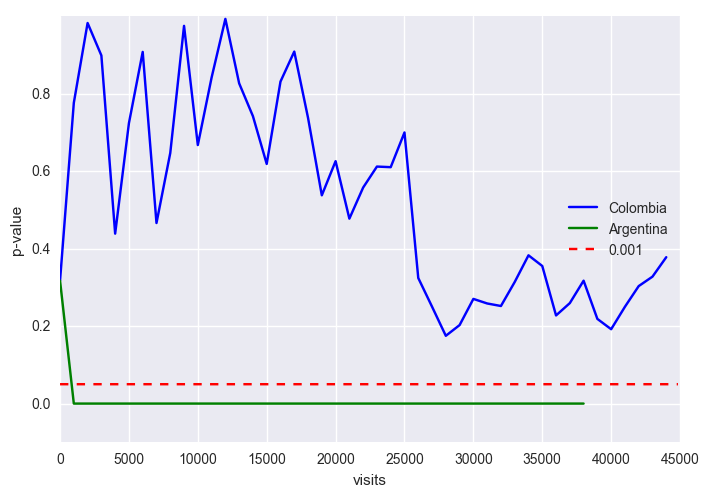

In [61]:
n = 1000
p = 0.05
plt.plot(np.arange(len(df_col))[::n],df_col['p_value'][::n],'b-',label='Colombia')
#plt.plot(np.arange(len(df_uru))[::n],df_uru['p_value'][::n],'g-',label='Uruguay')
plt.plot(np.arange(len(df_arg))[::n],df_arg['p_value'][::n],'g-',label='Argentina')
plt.plot(np.arange(len(df_col)),[p]*len(df_col),'r-',label='0.001',linestyle='--')
plt.xlabel('visits')
plt.legend(loc=7)

plt.ylabel('p-value')
#plt.yscale('log')
plt.ylim((-0.1,1))

In [51]:
df['country'].unique()

array(['Mexico', 'Venezuela', 'Bolivia', 'Colombia', 'Uruguay',
       'El Salvador', 'Nicaragua', 'Peru', 'Argentina', 'Chile', 'Ecuador',
       'Guatemala', 'Honduras', 'Paraguay', 'Panama', 'Costa Rica'], dtype=object)

In [52]:
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'date'])
df = df.sort_values('date')
df['control'] = 1-df['test']
df['test_size']=df.groupby('country')['test'].cumsum()
df['control_size']=df.groupby('country')['control'].cumsum()

In [53]:
df['p_value']=df[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]

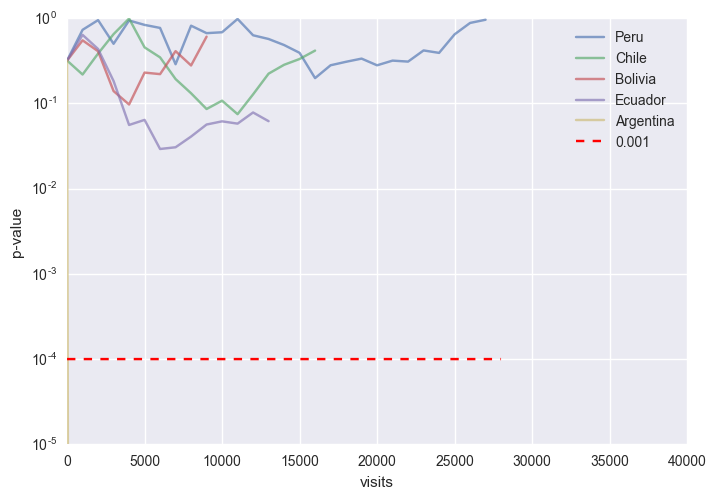

In [54]:
n = 1000
p = 0.0001
s = len(df[df['country']=='Peru'])
country_list = ['Peru','Chile','Bolivia','Ecuador','Argentina']
for country in country_list:
    x = df[df['country']==country]['test_size']+df[df['country']==country]['control_size']
    y = df[df['country']==country]['p_value'].values
    plt.plot(x[::n],y[::n],label=country,alpha=0.65)
plt.plot(np.arange(s),[p]*s,'r-',label='0.001',linestyle='--')
plt.legend()
plt.xlabel('visits')
plt.ylabel('p-value')
plt.yscale('log')
plt.ylim((1e-5,1));

In [55]:
df_2.groupby('test')['conversion'].count()

test
0    146267
1    145296
Name: conversion, dtype: int64